In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from sklearn.manifold import TSNE
import seaborn as sns

In [14]:
def line_interpolate(azi_line_integration, fixed_line_size = 300):
    '''
    Extend the line length into fixed size by interpolating new points 
    among the real ones

    ## Args
        - azi_line_integration: 1D azimuathal integration line
        - fixed_line_size: Need size of the line
    ## Return
        - New interpolated line
    '''
    # old line
    azi_line_size = len(azi_line_integration)
    x_old = np.linspace(0, 1, azi_line_size)

    # new interpolated line
    x_new = np.linspace(0, 1, fixed_line_size)
    y_new = np.interp(x_new, x_old, azi_line_integration)

    return y_new

In [21]:
def dft(image_path):
    '''
    Apply dft (Discrete fourier transform) to extract the frequency domain 
    for a given image

    ## Args
        - image_path: Relative image path
    ## Returns
        - The normalized magnitude of the set of image frequencies
    '''
    image = cv2.imread(image_path)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute the discrete Fourier Transform of the image
    fourier = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)

    # Shift the zero-frequency component to the center of the spectrum
    fourier_shift = np.fft.fftshift(fourier)

    # calculate the magnitude of the Fourier Transform
    magnitude = 20*np.log(cv2.magnitude(fourier_shift[:,:,0],fourier_shift[:,:,1]) + 1)

    return magnitude

In [22]:
def azimuthal_integration(freq_scale):
    '''
    The function azimuthal_integration calculate the radial/azimuthal power along 2D 
    spatial frequencies grid using this formula 
    AI(Wk) = integration 0 -> 2*Pi (f(wk * cos(phi), wk * sin(phi))), where phi is the azimuthal degree
    ## Args
        - freq_scale: The frequency domain of the image
    ## Return
        - Azimuthal integration values along wk 0 -> inf
    '''
    k, l = np.asarray(freq_scale).shape
    shift_row_idx, shift_col_idx = k // 2, l // 2
    
    # get the minimum dimension
    m = min(k, l)

    # initialize the azimuthal integration array
    azi_integ = np.zeros(m // 2)

    for wk in range(m // 2):
        current_theta_integration = 0
        theta = np.linspace(0, 2 * np.pi, 100)
        r = np.array(shift_row_idx + wk * np.sin(theta)).astype(int)
        c = np.array(shift_col_idx + wk * np.cos(theta)).astype(int)
        current_theta_integration = np.array(np.square(freq_scale[r, c])).sum()
        azi_integ[wk] = current_theta_integration

    
    # line normalization
    azi_integ /= azi_integ[0]
    
    # line interpolation to fixed size
    azi_integ = line_interpolate(azi_integ)
    
    return azi_integ



In [27]:
fake_dft = dft('test.jpg')
real_dft = dft('elon-musk.jpg')

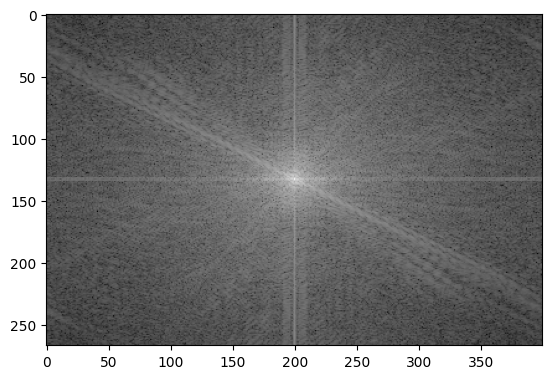

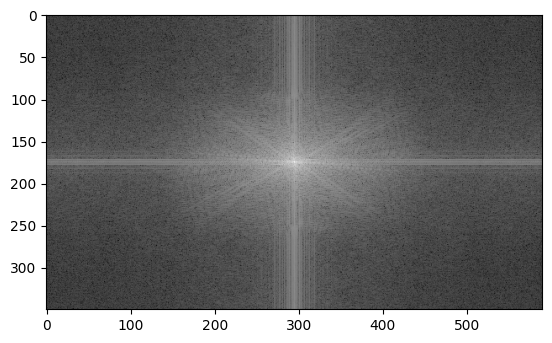

In [28]:
plt.imshow(real_dft, cmap='gray')
plt.show()
plt.imshow(fake_dft, cmap='gray')
plt.show()

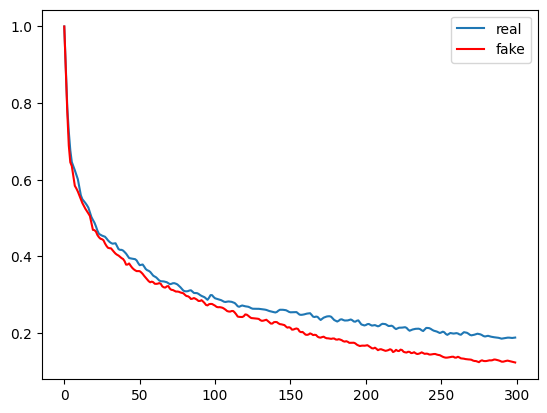

In [29]:
azi_int_real = azimuthal_integration(real_dft)
azi_int_fake = azimuthal_integration(fake_dft)

x1 = np.arange(len(azi_int_real))
x2 = np.arange(len(azi_int_fake))

plt.plot(x1, azi_int_real, label='real')
plt.plot(x2, azi_int_fake, c='r', label='fake')
plt.legend()
plt.show()

In [11]:
tsne = TSNE(n_components=2, verbose=1, perplexity=4, n_iter=4000)
point1 = tsne.fit_transform(azi_int.reshape((1, -1)))
point2 = tsne.fit_transform(azi_int2.reshape((1, -1)))

ValueError: perplexity must be less than n_samples